In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict, List

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from torch import nn

## 0 Import logits

In [2]:
MODEL_FOLDER = 'models_use_valid'
LIKELIHOOD = 'softmax'
EPOCH = 299

In [3]:
logits_val, targets_val, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='val')
logits_test, targets_test, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='test')
logits_train, targets_train, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False, logits_type='train')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
targets_train.shape, targets_val.shape, targets_test.shape

(torch.Size([45000]), torch.Size([5000]), torch.Size([10000]))

In [5]:
# TODO: fit a model only on train data, then predict on val and test data
(logits_test[0].argmax(axis=1) == targets_test).sum() / len(targets_test), (logits_val[0].argmax(axis=1) == targets_val).sum() / len(targets_val), (logits_train[0].argmax(axis=1) == targets_train).sum() / len(targets_train)

(tensor(0.6128), tensor(0.5990), tensor(0.9013))

In [6]:
L, N = len(logits_test), len(targets_test)

probs = torch.softmax(logits_test, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets_test == preds[i]).sum() / len(targets_test) for i in range(L)]

T = 1.
probs_poe_ovr = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits_test, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets_test == preds_poe_ovr[i]).sum() / len(targets_test) for i in range(L)]

logits_poe = logits_test.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets_test == preds_poe[i]).sum() / len(targets_test) for i in range(L)]


probs_ovr = torch.tensor(f_probs_ovr_logits_weighted(logits_test))
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets_test == preds_ovr[i]).sum() / len(targets_test) for i in range(L)]

probs_ovr_thres_5 = torch.tensor(f_probs_ovr_logits_weighted(logits_test, threshold=5.))
preds_ovr_thres_5 = {i: torch.argmax(probs_ovr_thres_5, dim=2)[i, :] for i in range(L)}
acc_ovr_thres_5 = [(targets_test == preds_ovr_thres_5[i]).sum() / len(targets_test) for i in range(L)]

## 1 Logistic regression on validation data

In [7]:
K = 2

In [8]:
log_reg_val = fit_log_reg(logits_val, targets_val, K=K)

/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:803: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_K_logits, _ = torch.topk(torch.tensor(logits[l]), K, dim=1)


In [9]:
C_dict_val = grid_search_adapt_thres(logits_val, targets_val, log_reg_val, K=K)
C_dict_test_w_log_reg_val = grid_search_adapt_thres(logits_test, targets_test, log_reg_val, K=K)

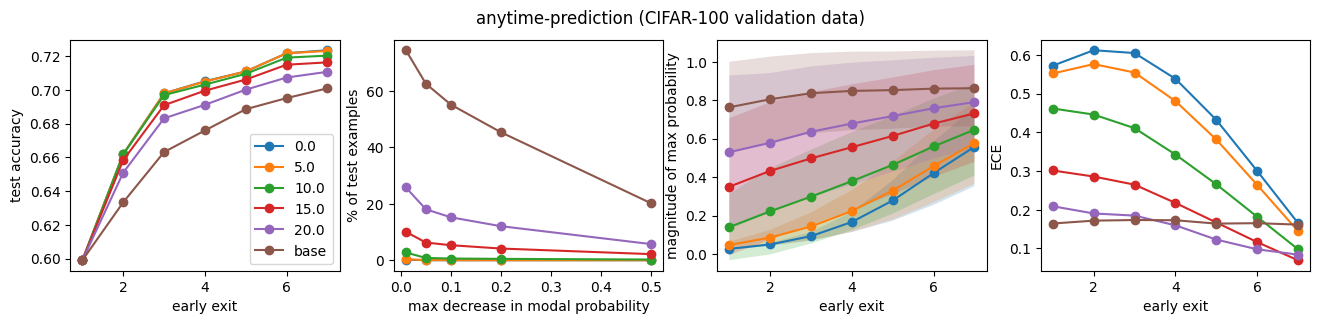

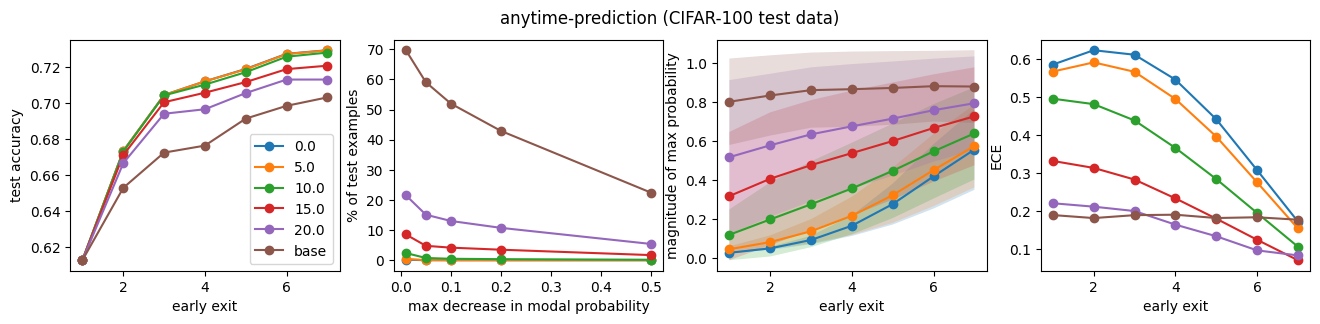

In [10]:
for _logits, _targets, _dict, _label in zip([logits_val, logits_test], [targets_val, targets_test], [C_dict_val, C_dict_test_w_log_reg_val], ['validation', 'test']):
    plot_adapt_thres(_logits, _targets, _dict, _label)
    

In [11]:
# C = 15 yields best ECE while not impacting accuracy and monotonicity too much
C_val = 15.

probs_poe_ovr_adapt_thres_log_reg_val, preds_poe_ovr_adapt_thres_log_reg_val, acc_poe_ovr_adapt_thres_log_reg_val = C_dict_test_w_log_reg_val[C_val]

## 2 Logistic Regression on train data

In [12]:
log_reg_train = fit_log_reg(logits_train, targets_train)

/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:803: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_K_logits, _ = torch.topk(torch.tensor(logits[l]), K, dim=1)


In [13]:
C_dict_train = grid_search_adapt_thres(logits_train, targets_train, log_reg_train)
C_dict_test_w_log_reg_train = grid_search_adapt_thres(logits_test, targets_test, log_reg_train)

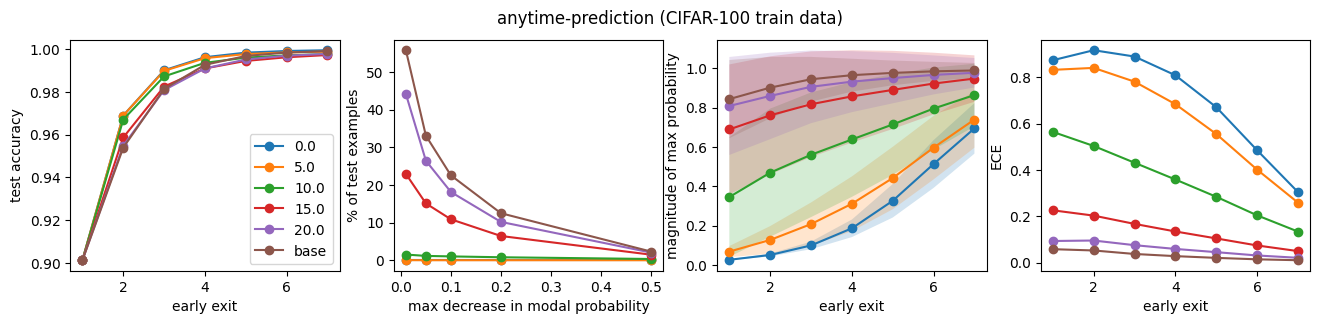

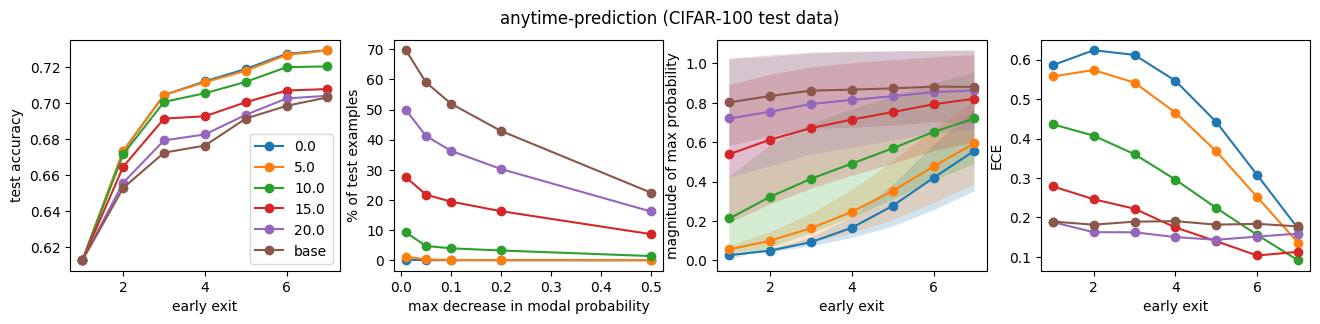

In [14]:
for _logits, _targets, _dict, _label in zip([logits_train, logits_test], [targets_train, targets_test], [C_dict_train, C_dict_test_w_log_reg_train], ['train', 'test']):
    plot_adapt_thres(_logits, _targets, _dict, _label)

In [15]:
# C = 15 yields best ECE while not impacting accuracy and monotonicity too much
C_train = 10.

probs_poe_ovr_adapt_thres_log_reg_train, preds_poe_ovr_adapt_thres_log_reg_train, acc_poe_ovr_adapt_thres_log_reg_train = C_dict_test_w_log_reg_train[C_train]

## 3 Simple binary adaptive thresholding

In [16]:
# CIFAR-10
# probs_poe_ovr_break_ties_generalized_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits[:, n, :], weights=(np.arange(1, L + 1, 1, dtype=float) / L), thres_metric=5, thres_easy=6)) for n in range(N)], axis=1)

# CIFAR-100
probs_poe_ovr_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits_test[:, n, :], 
                                                                                                 weights=(np.arange(1, L + 1, 1, dtype=float) / L))) for n in range(N)], 
                                                                                                 axis=1)

probs_poe_ovr_adapt_thres = torch.tensor(probs_poe_ovr_adapt_thres)
preds_poe_ovr_adapt_thres = {i: torch.argmax(probs_poe_ovr_adapt_thres, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_adapt_thres = [(targets_test == preds_poe_ovr_adapt_thres[i]).sum() / len(targets_test) for i in range(L)]

## 4 Summary Adaptive Thresholds

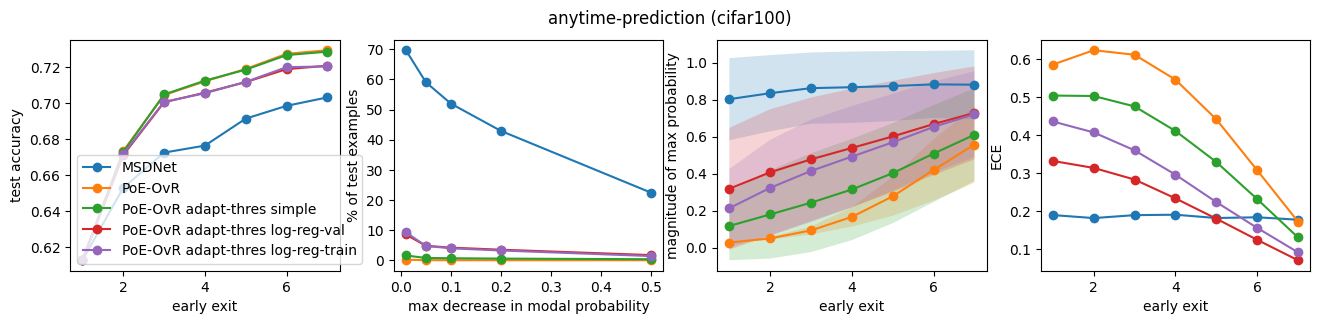

In [17]:
L, N = len(logits_test), len(targets_test)
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 4, figsize=(16, 3))


for _preds, _probs, _acc, label in [
                            (preds, probs, acc, 'MSDNet'),
                            (preds_poe_ovr, probs_poe_ovr, acc_poe_ovr, 'PoE-OvR'),
                            (preds_poe_ovr_adapt_thres, probs_poe_ovr_adapt_thres, acc_poe_ovr_adapt_thres, 'PoE-OvR adapt-thres simple'),
                            (preds_poe_ovr_adapt_thres_log_reg_val, probs_poe_ovr_adapt_thres_log_reg_val, acc_poe_ovr_adapt_thres_log_reg_val, 'PoE-OvR adapt-thres log-reg-val'),
                            (preds_poe_ovr_adapt_thres_log_reg_train, probs_poe_ovr_adapt_thres_log_reg_train, acc_poe_ovr_adapt_thres_log_reg_train, 'PoE-OvR adapt-thres log-reg-train'),
                            ]:

    ax[0].plot(early_exits, _acc, label=label, marker='o',)

    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    mean_magnitude, std_magnitude = _probs.max(2).values.mean(1), _probs.max(2).values.std(1)

    ax[2].plot(early_exits, mean_magnitude, marker='o', label=label)
    ax[2].fill_between(early_exits, mean_magnitude - std_magnitude, mean_magnitude + std_magnitude, alpha=0.2)

    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets_test.numpy()))
    ax[3].plot(early_exits, ece, marker='o', label=label)


ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')

ax[2].set_xlabel('early exit')
ax[2].set_ylabel('magnitude of max probability')

ax[3].set_xlabel('early exit')
ax[3].set_ylabel('ECE')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

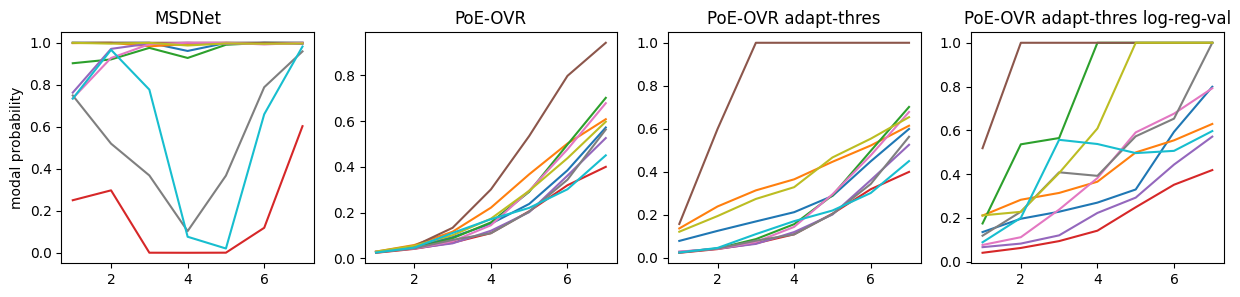

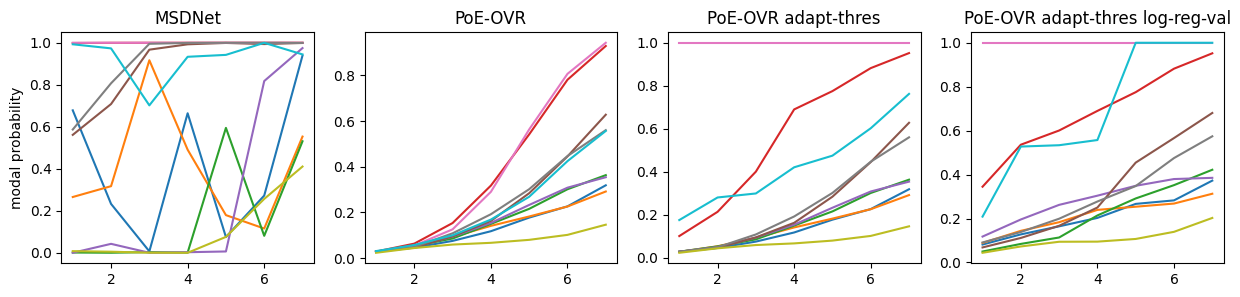

In [18]:
for _ in range(2):
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = probs_poe_ovr[:, i, preds_poe_ovr[L - 1][i]].cpu()
        probs_adapt_thres_i = probs_poe_ovr_adapt_thres[:, i, preds_poe_ovr_adapt_thres[L - 1][i]].cpu()
        probs_adapt_thres_log_reg_val_i = probs_poe_ovr_adapt_thres_log_reg_val[:, i, preds_poe_ovr_adapt_thres_log_reg_val[L - 1][i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
        ax[2].plot(list(range(1, len(probs_adapt_thres_i) + 1)), probs_adapt_thres_i, label=f'{i}');
        ax[3].plot(list(range(1, len(probs_adapt_thres_log_reg_val_i) + 1)), probs_adapt_thres_log_reg_val_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('MSDNet')
    ax[1].set_title('PoE-OVR')
    ax[2].set_title('PoE-OVR adapt-thres')
    ax[3].set_title('PoE-OVR adapt-thres log-reg-val')
    ax[0].set_ylabel('modal probability')
    plt.show()

In [19]:
quantiles = np.arange(0.1, 1., 0.05)

thres_arr_hetero = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr_adapt_thres = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val = {q: [] for q in quantiles}
_probs = probs.max(dim=2).values
_probs_poe_ovr = probs_poe_ovr.max(dim=2).values
_probs_poe_ovr_adapt_thres = probs_poe_ovr_adapt_thres.max(dim=2).values
_probs_poe_ovr_adapt_thres_log_reg_val = probs_poe_ovr_adapt_thres_log_reg_val.max(dim=2).values
for l in range(L):
    for q in quantiles:
        thres_arr_hetero[q].append(np.quantile(_probs[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr[q].append(np.quantile(_probs_poe_ovr[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr_adapt_thres[q].append(np.quantile(_probs_poe_ovr_adapt_thres[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val[q].append(np.quantile(_probs_poe_ovr_adapt_thres_log_reg_val[l, :].flatten(), q))

In [20]:
budget_dict_hetero = {name: [] for name in ['MSDNet', 'PoE-OVR', 'PoE-OVR adapt-thres', 'PoE-OVR adapt-thres log-reg-val']}
for name, _thres_arr, _probs in zip(['MSDNet', 'PoE-OVR', 'PoE-OVR adapt-thres', 'PoE-OVR adapt-thres log-reg-val'], 
                                    [thres_arr_hetero, thres_arr_hetero_poe_ovr, thres_arr_hetero_poe_ovr_adapt_thres, thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val], 
                                    [probs, probs_poe_ovr, probs_poe_ovr_adapt_thres, probs_poe_ovr_adapt_thres_log_reg_val]):
    for thres_quantile in _thres_arr.keys():
        _preds_terminated = []
        for n in range(N):
            exited = False
            for l in range(L):
                if _probs[l, n, :].max() >= _thres_arr[thres_quantile][l]:
                    _preds_terminated.append((l+ 1, _probs[l, n, :].argmax()))
                    exited = True
                    break
            if not exited:
                _preds_terminated.append((L, _probs[L - 1, n, :].argmax()))
        budget_dict_hetero[name].append((float((torch.stack([x[1] for x in _preds_terminated]) == targets_test).sum() / N), 
                                         np.mean([x[0] for x in _preds_terminated]), 
                                         thres_quantile))

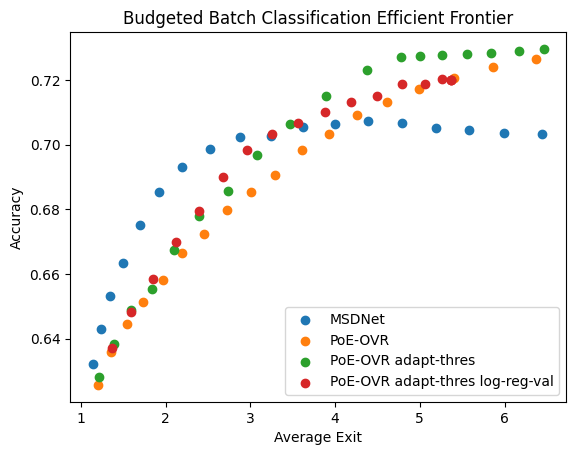

In [21]:
plt.scatter([x[1] for x in budget_dict_hetero['MSDNet']], [x[0] for x in budget_dict_hetero['MSDNet']], label='MSDNet', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR']], [x[0] for x in budget_dict_hetero['PoE-OVR']], label='PoE-OVR', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR adapt-thres']], [x[0] for x in budget_dict_hetero['PoE-OVR adapt-thres']], label='PoE-OVR adapt-thres', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR adapt-thres log-reg-val']], [x[0] for x in budget_dict_hetero['PoE-OVR adapt-thres log-reg-val']], label='PoE-OVR adapt-thres log-reg-val', marker='o')
# plt.scatter([1], [1], label='oracle', marker='o', color='tab:red')
plt.xlabel('Average Exit')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Budgeted Batch Classification Efficient Frontier')
plt.show()

## 5 Ablations for Budgeted Batch Classification

In [22]:
quantiles = np.arange(0.1, 1., 0.05)

thres_arr_hetero = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr = {q: [] for q in quantiles}
thres_arr_hetero_poe = {q: [] for q in quantiles}
thres_arr_hetero_ovr = {q: [] for q in quantiles}
thres_arr_hetero_ovr_thres_5 = {q: [] for q in quantiles}

_probs = probs.max(dim=2).values
_probs_poe_ovr = probs_poe_ovr.max(dim=2).values
_probs_poe = probs_poe.max(dim=2).values
_probs_ovr = probs_ovr.max(dim=2).values
_probs_ovr_thres_5 = probs_ovr_thres_5.max(dim=2).values
for l in range(L):
    for q in quantiles:
        thres_arr_hetero[q].append(np.quantile(_probs[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr[q].append(np.quantile(_probs_poe_ovr[l, :].flatten(), q))
        thres_arr_hetero_poe[q].append(np.quantile(_probs_poe[l, :].flatten(), q))
        thres_arr_hetero_ovr[q].append(np.quantile(_probs_ovr[l, :].flatten(), q))
        thres_arr_hetero_ovr_thres_5[q].append(np.quantile(_probs_ovr_thres_5[l, :].flatten(), q))

In [23]:
budget_dict_hetero = {name: [] for name in ['MSDNet', 'PoE-OVR', 'PoE', 'OvR', 'OvR-5']}
for name, _thres_arr, _probs in zip(['MSDNet', 'PoE-OVR', 'PoE', 'OvR', 'OvR-5'], 
                                    [thres_arr_hetero, thres_arr_hetero_poe_ovr, thres_arr_hetero_poe, thres_arr_hetero_ovr, thres_arr_hetero_ovr_thres_5], 
                                    [probs, probs_poe_ovr, probs_poe, probs_ovr, probs_ovr_thres_5]):
    for thres_quantile in _thres_arr.keys():
        _preds_terminated = []
        for n in range(N):
            exited = False
            for l in range(L):
                if _probs[l, n, :].max() >= _thres_arr[thres_quantile][l]:
                    _preds_terminated.append((l+ 1, _probs[l, n, :].argmax()))
                    exited = True
                    break
            if not exited:
                _preds_terminated.append((L, _probs[L - 1, n, :].argmax()))
        budget_dict_hetero[name].append((float((torch.stack([x[1] for x in _preds_terminated]) == targets_test).sum() / N), 
                                         np.mean([x[0] for x in _preds_terminated]), 
                                         thres_quantile))

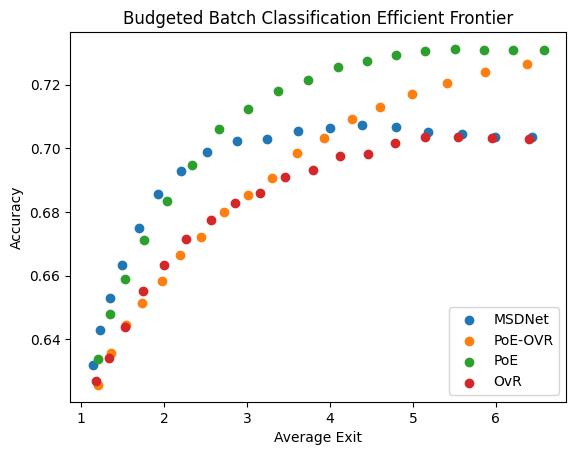

In [24]:
plt.scatter([x[1] for x in budget_dict_hetero['MSDNet']], [x[0] for x in budget_dict_hetero['MSDNet']], label='MSDNet', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR']], [x[0] for x in budget_dict_hetero['PoE-OVR']], label='PoE-OVR', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE']], [x[0] for x in budget_dict_hetero['PoE']], label='PoE', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['OvR']], [x[0] for x in budget_dict_hetero['OvR']], label='OvR', marker='o')
# plt.scatter([x[1] for x in budget_dict_hetero['OvR-5']], [x[0] for x in budget_dict_hetero['OvR-5']], label='OvR-5', marker='o')
# plt.scatter([1], [1], label='oracle', marker='o', color='tab:red')
plt.xlabel('Average Exit')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Budgeted Batch Classification Efficient Frontier')
plt.show()

## 6 Ranking of sorted IDs analysis

In [43]:
l = 0

logits_sorted_ids = logits_test[l].max(dim=1).values.argsort(descending=True).numpy()
probs_sorted_ids = probs[l].max(dim=1).values.argsort(descending=True).numpy()
probs_ovr_sorted_ids = probs_ovr[l].max(dim=1).values.argsort(descending=True).numpy()

assert (preds[l] == preds_ovr[l]).sum() == N

dict_sorted_ids = {'correct': {'softmax': [], 'ovr': []}, 'incorrect': {'softmax': [], 'ovr': []}}
for i, id in enumerate(logits_sorted_ids):
    id_softmax = np.where(probs_sorted_ids == id)[0][0]
    id_ovr = np.where(probs_ovr_sorted_ids == id)[0][0]
    if preds[l][id] == targets_test[id]:
        dict_sorted_ids['correct']['softmax'].append(i - id_softmax)
        dict_sorted_ids['correct']['ovr'].append(i - id_ovr)
    else:
        dict_sorted_ids['incorrect']['softmax'].append(i - id_softmax)
        dict_sorted_ids['incorrect']['ovr'].append(i - id_ovr)

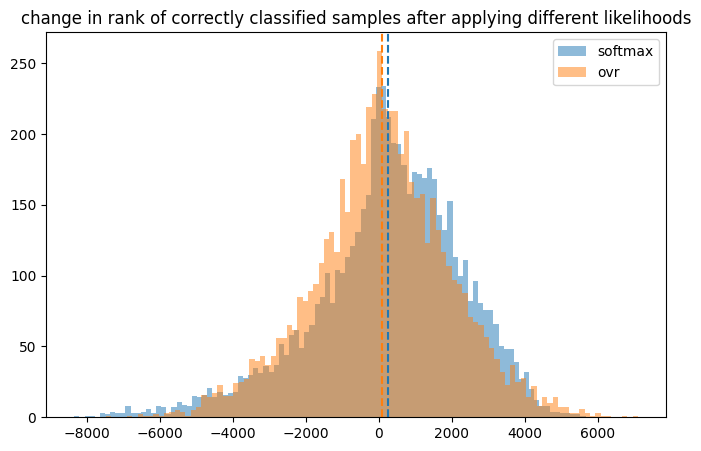

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.hist(dict_sorted_ids['correct']['softmax'], bins=100, label='softmax', alpha=0.5)
plt.hist(dict_sorted_ids['correct']['ovr'], bins=100, label='ovr', alpha=0.5)
plt.axvline(x=np.mean(dict_sorted_ids['correct']['softmax']), color='tab:blue', linestyle='--')
plt.axvline(x=np.mean(dict_sorted_ids['correct']['ovr']), color='tab:orange', linestyle='--')
plt.title('change in rank of correctly classified samples after applying different likelihoods')
plt.legend()
plt.show()

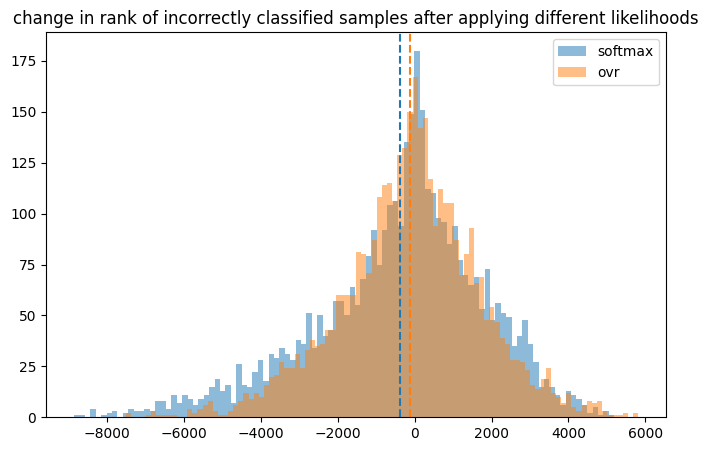

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.hist(dict_sorted_ids['incorrect']['softmax'], bins=100, label='softmax', alpha=0.5)
plt.hist(dict_sorted_ids['incorrect']['ovr'], bins=100, label='ovr', alpha=0.5)
plt.axvline(x=np.mean(dict_sorted_ids['incorrect']['softmax']), color='tab:blue', linestyle='--')
plt.axvline(x=np.mean(dict_sorted_ids['incorrect']['ovr']), color='tab:orange', linestyle='--')
plt.title('change in rank of incorrectly classified samples after applying different likelihoods')
plt.legend()
plt.show()

## 7 Impact of likelihood on the sorting of test samples

In [68]:
probs_logits_add_min = logits_test[0] + logits_test[0].min(dim=1).values.abs()[:, None]
probs_logits_add_min = probs_logits_add_min / probs_logits_add_min.sum(dim=1).unsqueeze(1)

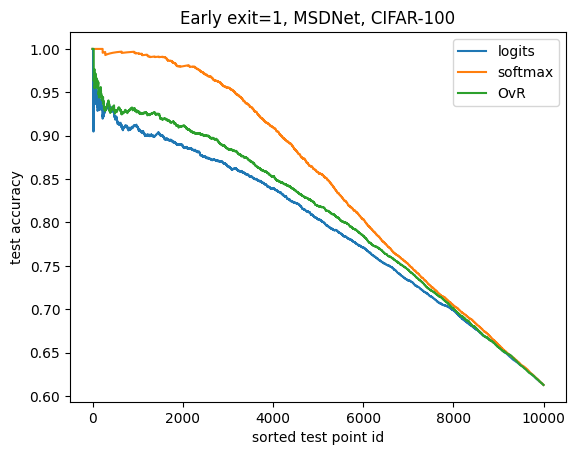

In [95]:
l = 0

plt.plot((targets_test == preds[l])[logits_test[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits')
plt.plot((targets_test == preds[l])[probs[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='softmax')
plt.plot((targets_test == preds[l])[probs_ovr[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='OvR')
# plt.plot((targets_test == preds_poe_ovr[l])[probs_poe_ovr[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='PoE-OvR')
# plt.plot((targets_test == preds[0])[probs_ovr_thres_5[0].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='OvR-5')
# plt.plot((targets_test == preds[0])[probs_logits_add_min.max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='OvR-add-min')
# plt.plot(np.linspace(0, 10000, 10000), np.linspace(0, 10000, 10000), label='oracle', color='black', linestyle='--')
# plt.ylim(0, 7000)
plt.xlabel('sorted test point id')
plt.ylabel('test accuracy')
plt.title(f'Early exit={l + 1}, MSDNet, CIFAR-100')
plt.legend()
plt.show()

In [75]:
bucket_arr_prob = []
bucket_arr_ovr = []
for i in range(10):
    bucket_arr_ovr.append((targets_test == preds[0])[probs_ovr[0].max(dim=1).values.argsort(descending=True).numpy()].int().numpy()[i * 1000:(i + 1) * 1000].sum() / 1000)
    bucket_arr_prob.append((targets_test == preds[0])[probs[0].max(dim=1).values.argsort(descending=True).numpy()].int().numpy()[i * 1000:(i + 1) * 1000].sum() / 1000)

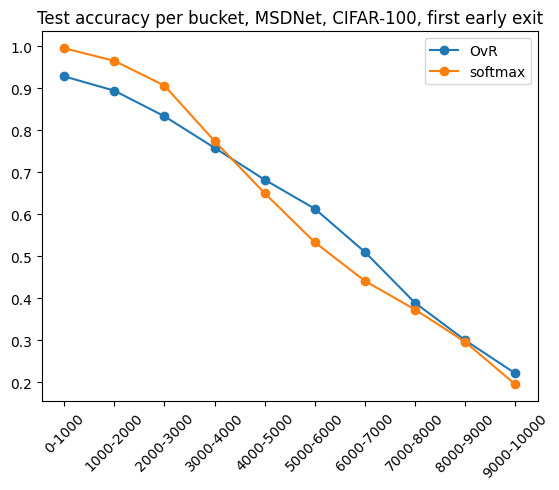

In [76]:
plt.plot(bucket_arr_ovr, label='OvR', marker='o')
plt.plot(bucket_arr_prob, label='softmax', marker='o')
plt.xticks(np.arange(10), [str(i * 1000) + '-' + str((i + 1) * 1000) for i in range(10)])
# rotate xticks
plt.xticks(rotation=45)
plt.title('Test accuracy per bucket, MSDNet, CIFAR-100, first early exit')
plt.legend()
plt.show()

## 8 Calibration and Budgeted Batch Classification

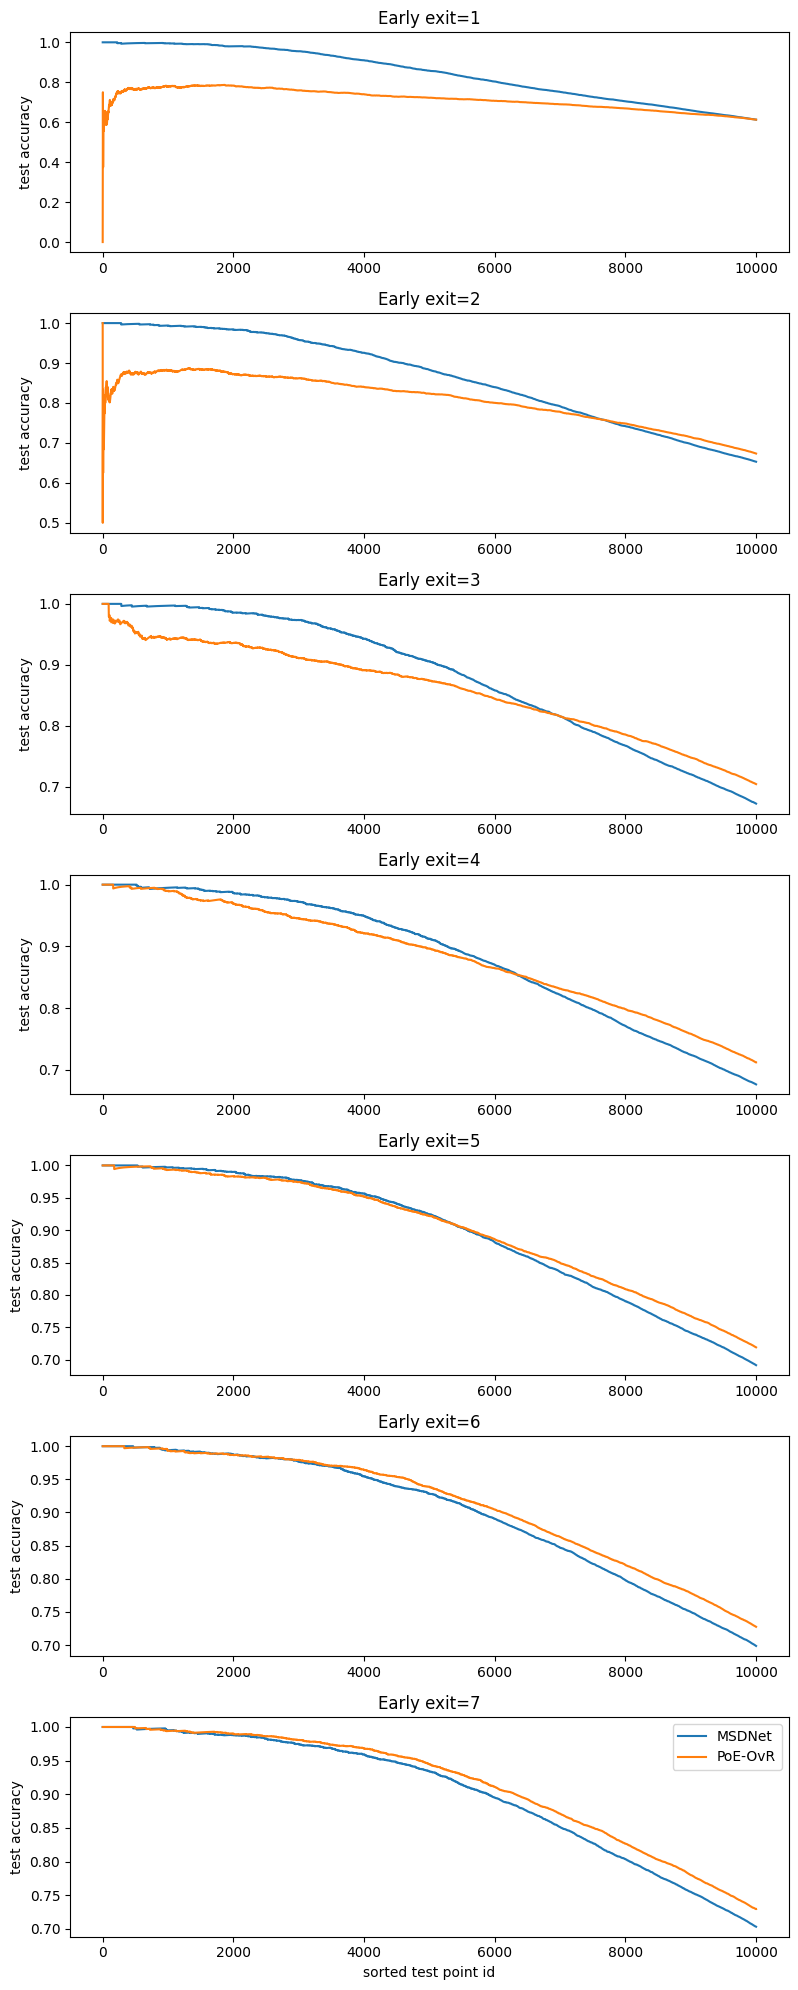

In [102]:
fig, ax = plt.subplots(7, 1, figsize=(8, 20))
for l in range(L):
    ax[l].plot((targets_test == preds[l])[probs[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='MSDNet')
    ax[l].plot((targets_test == preds_poe_ovr[l])[probs_poe_ovr[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='PoE-OvR')
    ax[l].set_ylabel('test accuracy')
    ax[l].set_title(f'Early exit={l + 1}')
    
plt.xlabel('sorted test point id')
# plt.suptitle('MSDNet vs PoE-OvR, CIFAR-100')
plt.tight_layout()
plt.legend()
plt.show()

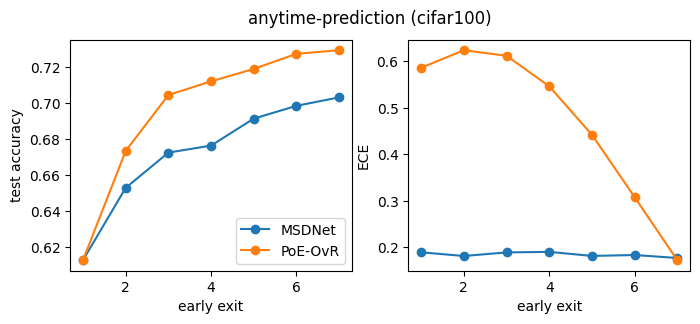

In [104]:
L, N = len(logits_test), len(targets_test)
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(8, 3))


for _preds, _probs, _acc, label in [
                            (preds, probs, acc, 'MSDNet'),
                            (preds_poe_ovr, probs_poe_ovr, acc_poe_ovr, 'PoE-OvR'),
                            ]:

    ax[0].plot(early_exits, _acc, label=label, marker='o',)

    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets_test.numpy()))
    ax[1].plot(early_exits, ece, marker='o', label=label)


ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

ax[1].set_xlabel('early exit')
ax[1].set_ylabel('ECE')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

## 9 Ratio of top logit vs the rest for different likelihoods

TODO

In [103]:
relu = nn.ReLU()

In [127]:
correct = [i for i in range(len(targets_test)) if targets_test[i] == preds[0][i]]
incorrect = [i for i in range(len(targets_test)) if targets_test[i] != preds[0][i]]

In [128]:
len(correct) + len(incorrect)

10000

In [152]:
prob_ground_truth = []
prob_rest = []
for n in correct:
    # label = targets_test[n]
    label = preds[0][n]
    rest = [c for c in range(100) if c != label]
    prob_ground_truth.append(float(logits_test[0, n, label].exp()))
    prob_rest.append(float(logits_test[0, n, rest].exp().sum()))
    # prob_ground_truth.append(float(relu(logits_test[0, n, label])))
    # prob_rest.append(float(relu(logits_test[0, n, rest]).sum()))

In [149]:
# incorrect OvR
np.mean(prob_ground_truth), np.mean(prob_rest), np.mean([x / y for x, y in zip(prob_ground_truth, prob_rest)])

(15.456134980375117, 214.3506386260356, 0.07212225857049374)

In [147]:
# correct OvR
np.mean(prob_ground_truth), np.mean(prob_rest), np.mean([x / y for x, y in zip(prob_ground_truth, prob_rest)])

(20.80714700310722, 225.4183034349048, 0.0927734256987952)

In [155]:
214/225

0.9511111111111111

In [151]:
# incorrect softmax
np.mean(prob_ground_truth), np.mean(prob_rest), np.mean([x / y for x, y in zip(prob_ground_truth, prob_rest)])

(509958074249824.1, 26862322141357.28, 202.84960464065614)

In [153]:
# correct softmax
np.mean(prob_ground_truth), np.mean(prob_rest), np.mean([x / y for x, y in zip(prob_ground_truth, prob_rest)])

(1.841605451522317e+18, 19165130012979.33, 8218999.571365579)

In [154]:
26862322141357.28 / 19165130012979.33

1.4016248323473481

In [105]:
logits_test[0, ~(targets_test == preds[0]),: ].exp().sum(dim=1).mean() / logits_test[0, targets_test == preds[0],: ].exp().sum(dim=1).mean()

tensor(0.0003)

In [106]:
relu(logits_test[0, ~(targets_test == preds[0]),: ]).sum(dim=1).mean() / relu(logits_test[0, targets_test == preds[0],: ]).sum(dim=1).mean()

tensor(0.9333)